In [3]:
%pylab inline
import json 
import os
import re
import boto3
import uuid
import base64
import sagemaker as sm
import subprocess
from glob import glob
from tqdm import tqdm
from PIL import Image
from tracking_funcs import *
import datetime
import numpy as np
from scipy.spatial import distance
from matplotlib import patches
from sagemaker.predictor import RealTimePredictor
from sagemaker.predictor import numpy_deserializer, npy_serializer 

# realPredictor = RealTimePredictor(endpointName, serializer= npy_serializer, deserializer= numpy_deserializer)
# you need to remake this using different data. Cannot use NFL data here. 

sagemaker_cl = boto3.client('sagemaker')
sagemaker_rt = boto3.client('runtime.sagemaker')
bucket = 'privisaa-bucket-virginia' # sagemaker_session.default_bucket()
s3 = boto3.client('s3')

WORKTEAM_ARN = 'arn:aws:sagemaker:us-east-1:209419068016:workteam/private-crowd/ijp-private-workteam'


Populating the interactive namespace from numpy and matplotlib


In [1]:
!pip install norfair

     |████████████████████████████████| 150 kB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 34.7 MB/s eta 0:00:01
     |████████████████████████████████| 948 kB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 13.8 MB/s  eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110449 sha256=f6aeb8cb66a68462dd957b483110b29f5c05ed5a3797d89116f8e9eb303f3b5f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/21/d4/10/5b385d83d179d1c83bda7424f080a92023de3b316ab2c3ae43
Successfully built filterpy
ERROR: spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 4.0.1 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.5.2
    Uninstalling Pygments-2.5.2:
      Successfully uninstalled Pygments-2.5.2
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/

## Create label categories

In [4]:
# create label categories 

os.makedirs('/home/ec2-user/SageMaker/tracking_manifests', exist_ok=True)

labelcats = {
    "document-version": "2020-08-15",
    "auditLabelAttributeName": "Person",
    "labels": [
        {
            "label": "Parcel",
            "attributes": [
                {
                    "name": "color",
                    "type": "string",
                    "enum": [
                        "Bag",
                        "Jacket",
                        "Backpack"
                    ]
                }
            ]
        }
    ],
    "instructions": {
        "shortInstruction": "Draw boxes around all parcels in the pictures",
        "fullInstruction": "Some useful instruction"
    }
}

filename = '/home/ec2-user/SageMaker/tracking_manifests/label_categories.json'
with open(filename,'w') as f:
    json.dump(labelcats,f)

s3.upload_file(Filename=filename, Bucket=bucket, Key='tracking_manifests/label_categories.json')

LABEL_CATEGORIES_S3_URI = f's3://{bucket}/tracking_manifests/label_categories.json'

## Get our target video and frames

In [5]:
# get our target MP4 files, 
vids = glob('MOT20/MOT20/train/*') # '/home/ec2-user/SageMaker/game_clips/2020*'
vids.sort()
vids

# we assume we have folders with the same name as the mp4 file in the same root folder
vid_dict = {}
for vid in vids:
    files = glob(f"{vid}/img1/*jpg")
    files.sort()
    files = files[:1000]
    fileset = []
    for fil in files:
        fileset.append('/'.join(fil.split('/')[5:])) # may need to change this index
    vid_dict[vid] = fileset

## Generate a sequence file

In [6]:
# # generate sequences 
# all_vids = {}
# for vid in vid_dict:
#     frames = []
#     for i,v in enumerate(vid_dict[vid]):
#         frame =         {
#           "frame-no": i+1,
#           "frame": f"{v.split('/')[-1]}",
#           "unix-timestamp": 1589350528
#         }
#         frames.append(frame)
#     all_vids[vid] = {
#       "version": "2020-07-01",
#       "seq-no": 1,
#       "prefix": f"s3://{bucket}/nfl-data/live_video/{v.split('/')[1]}/",
#       "number-of-frames": len(vid_dict[vid]),
#       "frames": frames
#     }

# generate sequences 
all_vids = {}
for vid in vid_dict:
    frames = []
    for i,v in enumerate(vid_dict[vid]):
        frame =         {
          "frame-no": i+1,
          "frame": f"{v.split('/')[-1]}",
          "unix-timestamp": time.time()
        }
        frames.append(frame)
    all_vids[vid] = {
      "version": "2020-07-01",
      "seq-no": 1,
      "prefix": f"s3://{bucket}/{'/'.join(v.split('/')[:-1])}/", # .split('/')[1]
      "number-of-frames": len(vid_dict[vid]),
      "frames": frames
    }
    
# save sequences
for vid in all_vids:
    with open(f"/home/ec2-user/SageMaker/tracking_manifests/{vid.split('/')[-1]}_seq.json", 'w') as f:
        json.dump(all_vids[vid],f)

In [186]:
# # save sequences
# for vid in all_vids:
#     with open(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/{vid.split('/')[-1]}_seq.json", 'w') as f:
#         json.dump(all_vids[vid],f)

## Get predictions from our endpoint

In [8]:
#%%timeit
endpoint_name = 'd2-endpoint-Thu-Jul-16-15-24-57-2020'
vid = '/home/ec2-user/SageMaker/game_clips/2020-07-21-12:52:35.967499'

imgs = {}
preds = {}
# for vid in tqdm(vid_dict):
preds[vid] = []
imgs[vid] = []
for file in vid_dict[vid]:
    img = Image.open(f'/home/ec2-user/SageMaker/{file}')
    img = np.array(img, dtype=np.uint8) # np.uint8

    response = sagemaker_rt.invoke_endpoint(EndpointName=endpoint_name,
                                           ContentType='application/x-npy', # application/x-npy
                                           Body=npy_serializer(img)) # json.dumps(payload) # img.tobytes()
    response = eval(response['Body'].read().decode('utf-8'))
    preds[vid].append(response)
    imgs[vid].append(img)
        

KeyError: '/home/ec2-user/SageMaker/game_clips/2020-07-21-12:52:35.967499'

## View original frames

NameError: name 'imgs' is not defined

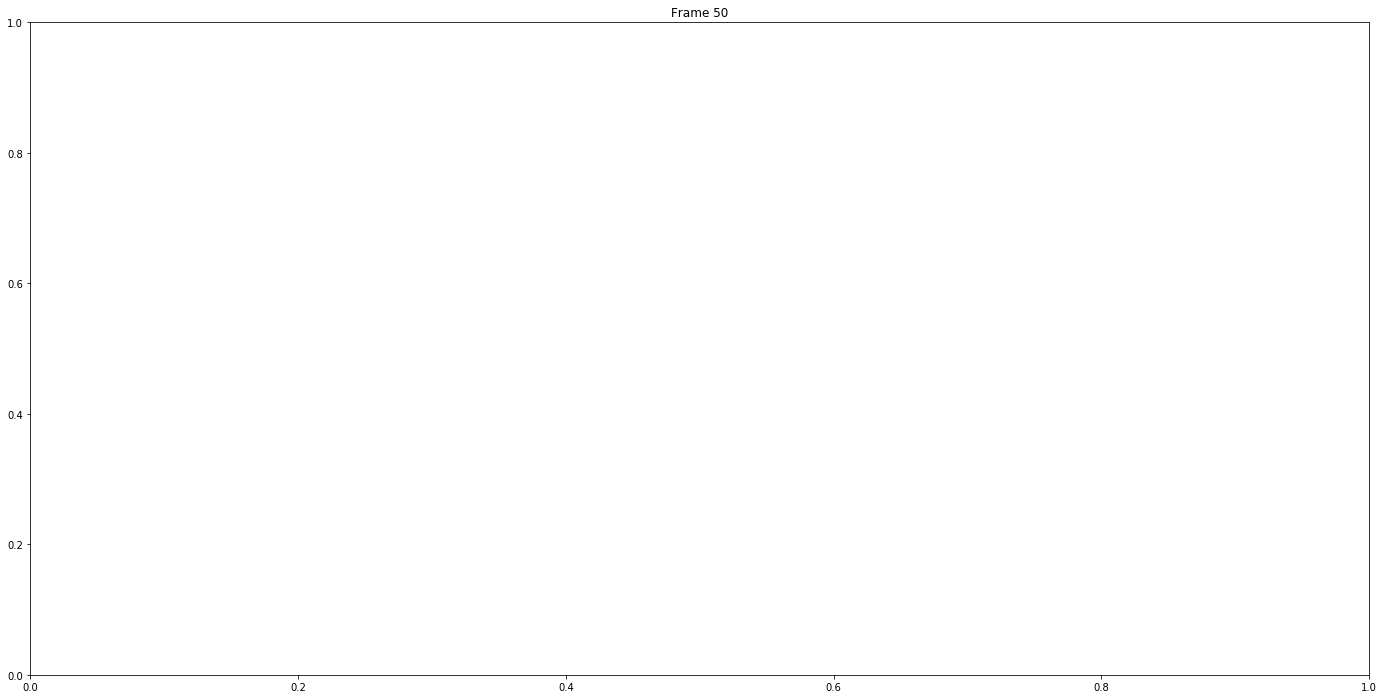

In [7]:
start_ind = 50
for j in range(start_ind,start_ind+2):

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(24,12))
    ax.set_title(f'Frame {j}')

    # Display the image
    ax.imshow(imgs[vid][j])

## View labeled frames

In [ ]:
start_ind = 50
for j in range(start_ind,start_ind+2): 

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(24,12))
    ax.set_title(f'Frame {j}')

    # Display the image
    ax.imshow(imgs[vid][j])

    for i,annot in enumerate(preds[vid][j]['pred_boxes']): 
        rect = patches.Rectangle((annot[0], annot[1]), annot[2]-annot[0], annot[3]-annot[1] ,linewidth=1,edgecolor='r',facecolor='none') # 50,100),40,30
        ax.add_patch(rect)
        plt.text(annot[0]-10, annot[1]-10, f"helmet", fontdict=None) # 

## Run our naive object tracker 

In [220]:
# get distances 
helmet_id_dict = {}

def get_object_ids(preds, verbose=False):
    helmet_dist = get_object_distances(preds)

    helmet_ids = {}
    helmet_id = []
    for i in helmet_dist:
        helmet_id = []
        for h in helmet_dist[i]:
            helmet_id.append(np.argmin(helmet_dist[i][h]))
        helmet_ids[i] = helmet_id

    if verbose:
        print(f'there are {len(find_dups(helmet_ids))} duplicates')   

    for i in range(7):
        dups = find_dups(helmet_ids)
        if verbose:
            print(f'dups before {dups}')
        helmet_ids = dedupe_helmets(dups, helmet_ids, helmet_dist, verbose=False)
        dups = find_dups(helmet_ids)
        if verbose:
            print(f'dups after {dups}')
    return helmet_ids
   

for vid in tqdm(preds):
    helmet_ids = get_object_ids(preds[vid], verbose=False)
    helmet_id_dict[vid] = helmet_ids

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


In [221]:
helmet_id_dict['/home/ec2-user/SageMaker/game_clips/2020-07-21-12:52:35.967499']

{1: [2, 0, 3, 1, 5, 4, 6, 8, 7, 9, 11, 10, 12],
 2: [2, 1, 6, 3, 4, 0, 5, 7, 9, 8, 10, 11, 12],
 3: [2, 3, 4, 6, 5, 1, 0, 8, 7, 11, 9, 10, 12],
 4: [4, 2, 0, 1, 7, 3, 5, 6, 8, 10, 9, 11, 12, 13, 14, 15],
 5: [1, 7, 5, 3, 0, 2, 6, 8, 9, 4, 11, 10, 12, 13],
 6: [5, 7, 0, 1, 3, 4, 2, 6, 9, 10, 11, 8, 12, 13],
 7: [1, 7, 0, 3, 2, 5, 6, 4, 9, 11, 10, 8, 12, 13, 14],
 8: [7, 4, 5, 0, 2, 3, 1, 6, 9, 10, 11, 13, 8, 12, 14],
 9: [0, 7, 1, 5, 4, 10, 3, 2, 6, 9, 8, 12, 11, 13],
 10: [7, 4, 1, 5, 0, 2, 3, 6, 9, 10, 8, 13, 12, 11],
 11: [3, 7, 1, 0, 4, 5, 13, 2, 10, 6, 12, 9, 8, 11, 14],
 12: [7, 5, 3, 2, 0, 10, 4, 9, 1, 12, 6, 13, 11, 8, 14, 15],
 13: [3, 7, 4, 0, 2, 5, 1, 10, 6, 12, 8, 11, 9, 13, 14],
 14: [3, 5, 0, 4, 7, 12, 6, 2, 10, 8, 9, 13, 11, 1],
 15: [3, 5, 7, 4, 0, 6, 12, 10, 9, 1, 2, 11, 8],
 16: [3, 0, 5, 10, 7, 4, 9, 1, 2, 12, 13, 6, 11, 14, 8],
 17: [5, 3, 0, 1, 7, 2, 4, 9, 12, 10, 11, 8, 6, 13],
 18: [7, 3, 5, 2, 4, 1, 9, 10, 0, 12, 8, 13, 6, 14],
 19: [3, 7, 5, 1, 9, 10, 13, 2, 0, 

## View results of our naive tracker

In [ ]:
start_ind = 1
for j in range(start_ind,start_ind+2): 

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(24,12))
    ax.set_title(f'Frame {j}')

    # Display the image
    ax.imshow(imgs[vid][j])

    for i,annot in enumerate(preds[vid][j]['pred_boxes']): 
#         print(helmet_ids[j][i],':',annot)
        rect = patches.Rectangle((annot[0], annot[1]), annot[2]-annot[0], annot[3]-annot[1] ,linewidth=1,edgecolor='r',facecolor='none') # 50,100),40,30
        ax.add_patch(rect)
        plt.text(annot[0]-10, annot[1]-10, f"helmet {helmet_ids[j][i]}", fontdict=None) # 

## Create our augmented manifest

In [222]:
annot_dict = {}
for vid in preds:
    annot_list = []
    for j in range(1,len(preds[vid])-1):
        annl = []
        for i,p in enumerate(preds[vid][j]['pred_boxes']):
            order_dict = {}
            try:
                idx = helmet_ids[j][i]
#                 print(idx,p)
            except:
                try:
                    idx = max(helmet_ids[j][i])+1
                except:
                    pass
            ann = {
                'class-id':'0',
#                 'label':'Helmet',
                'object-id':f'Helmet:{idx}',
                'object-name':f'H{idx}', # str(uuid.uuid1())
                'width':int(p[2]-p[0]),
                'top':int(p[1]),
                'height':int(p[3]-p[1]),
                'left':int(p[0]),
                'label-category-attributes':{}
            }
            annl.append(ann)

        annot = {
            'frame-no':j,
            'frame':all_vids[vid]['frames'][j-1]['frame'],
            'annotations':annl
        }
        annot_list.append(annot)

    annot_labels = {}
    annot_labels['tracking-annotations'] = annot_list
    annot_dict[vid] = annot_labels
    

In [192]:
# save labels
for vid in all_vids:
    with open(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/{vid.split('/')[-1]}-labels.json", 'w') as f:
        json.dump(annot_dict[vid],f)

## Combine our sequence file and generated labels

In [223]:
# create manifest 
man_dict = {}
for vid in all_vids:
    source_ref = f"s3://{bucket}/nfl-data/gt_jobs/{vid.split('/')[-1]}_seq.json"
#     print(source_ref)
    annot_labels = f"s3://{bucket}/nfl-data/gt_jobs/{vid.split('/')[-1]}-labels.json"

    manifest = {
        "source-ref": source_ref, 
     #describe_job['LabelAttributeName']: annot_labels, 
        'Person':annot_labels,
     #f"{describe_job['LabelAttributeName']}-metadata": 
        "Person-metadata":{"class-map": {"0": "Helmet"}, 
                         "human-annotated": "yes", 
                         "creation-date": "2020-05-25T12:53:54+0000", 
                         "type": "groundtruth/video-object-tracking"}}
    man_dict[vid] = manifest
    
manifest

{'source-ref': 's3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-21-12:52:35.967499_seq.json',
 'Person': 's3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-21-12:52:35.967499-labels.json',
 'Person-metadata': {'class-map': {'0': 'Helmet'},
  'human-annotated': 'yes',
  'creation-date': '2020-05-25T12:53:54+0000',
  'type': 'groundtruth/video-object-tracking'}}

In [194]:
# save labels
for vid in all_vids:
    with open(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/{vid.split('/')[-1]}.manifest", 'w') as f:
        json.dump(man_dict[vid],f)

In [195]:
# send files to s3

for file in glob(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/{vid.split('/')[-1]}*"):
    key = f"nfl-data/gt_jobs/{file.split('/')[-1]}"
    s3.upload_file(Filename=file,Bucket=bucket,Key=key)

## Generate our labeling job

In [210]:
# generate jobs 

job_names = []
outputs = []

# for vid in all_vids:
LABELING_JOB_NAME = f"helmet-track-example-t7-{vid.split('/')[-1].replace(':','-').split('.')[0]}"
vid = '/home/ec2-user/SageMaker/game_clips/2020-07-21-12:52:35.967499'
task = 'AdjustmentVideoObjectTracking'
job_names.append(LABELING_JOB_NAME)
#INPUT_MANIFEST_S3_URI = f"s3://{bucket}/nfl-data/gt_jobs/{vid.split('/')[-1]}.manifest"
INPUT_MANIFEST_S3_URI = 's3://privisaa-bucket-virginia/nfl-data/gt_jobs/helmet-track.manifest'

createLabelingJob_request = {
  "LabelingJobName": LABELING_JOB_NAME,
  "HumanTaskConfig": {
    "AnnotationConsolidationConfig": {
      "AnnotationConsolidationLambdaArn": f"arn:aws:lambda:us-east-1:432418664414:function:ACS-{task}"
    }, # changed us-west-2 to us-east-1
    "MaxConcurrentTaskCount": 200,
    "NumberOfHumanWorkersPerDataObject": 1,
    "PreHumanTaskLambdaArn": f"arn:aws:lambda:us-east-1:432418664414:function:PRE-{task}",
    "TaskAvailabilityLifetimeInSeconds": 864000,
    "TaskDescription": "Draw boxes around helmets!",
    "TaskKeywords": [
      "Image Classification",
      "Labeling"
    ],
    "TaskTimeLimitInSeconds": 28800,
    "TaskTitle": LABELING_JOB_NAME,
    "UiConfig": {
      "HumanTaskUiArn": f'arn:aws:sagemaker:us-east-1:394669845002:human-task-ui/VideoObjectTracking'
    },
    "WorkteamArn": WORKTEAM_ARN
  },
  "InputConfig": {
    "DataAttributes": {
      "ContentClassifiers": [
        "FreeOfPersonallyIdentifiableInformation",
        "FreeOfAdultContent"
      ]
    },
    "DataSource": {
      "S3DataSource": {
        "ManifestS3Uri": INPUT_MANIFEST_S3_URI
      }
    }
  },
  "LabelAttributeName": "Person-ref",
  "LabelCategoryConfigS3Uri": LABEL_CATEGORIES_S3_URI,
  "OutputConfig": {
    "S3OutputPath": f"s3://{bucket}/job_results"
  },
  "RoleArn": "arn:aws:iam::209419068016:role/service-role/AmazonSageMaker-ExecutionRole-20200212T154382",
  "StoppingConditions": {
    "MaxPercentageOfInputDatasetLabeled": 100
  }
}
print(createLabelingJob_request)
out = sagemaker_cl.create_labeling_job(**createLabelingJob_request)
outputs.append(out)
print(out)

{'LabelingJobName': 'helmet-track-example-t7-2020-07-21-12-52-35', 'HumanTaskConfig': {'AnnotationConsolidationConfig': {'AnnotationConsolidationLambdaArn': 'arn:aws:lambda:us-east-1:432418664414:function:ACS-AdjustmentVideoObjectTracking'}, 'MaxConcurrentTaskCount': 200, 'NumberOfHumanWorkersPerDataObject': 1, 'PreHumanTaskLambdaArn': 'arn:aws:lambda:us-east-1:432418664414:function:PRE-AdjustmentVideoObjectTracking', 'TaskAvailabilityLifetimeInSeconds': 864000, 'TaskDescription': 'Draw boxes around helmets!', 'TaskKeywords': ['Image Classification', 'Labeling'], 'TaskTimeLimitInSeconds': 28800, 'TaskTitle': 'helmet-track-example-t7-2020-07-21-12-52-35', 'UiConfig': {'HumanTaskUiArn': 'arn:aws:sagemaker:us-east-1:394669845002:human-task-ui/VideoObjectTracking'}, 'WorkteamArn': 'arn:aws:sagemaker:us-east-1:209419068016:workteam/private-crowd/ijp-private-workteam'}, 'InputConfig': {'DataAttributes': {'ContentClassifiers': ['FreeOfPersonallyIdentifiableInformation', 'FreeOfAdultContent']}

In [225]:
describe = sagemaker_cl.describe_labeling_job(LabelingJobName = out['LabelingJobArn'].split('/')[-1])
print(describe['LabelingJobStatus'])


InProgress


In [213]:
sagemaker_cl.stop_labeling_job(LabelingJobName='helmet-track-example-t3-2020-07-17-21-04-23')

{'ResponseMetadata': {'RequestId': '09a2aa18-8ee7-4ce8-9944-6fdfc2ff2acf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '09a2aa18-8ee7-4ce8-9944-6fdfc2ff2acf',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 07 Aug 2020 13:03:46 GMT'},
  'RetryAttempts': 0}}

In [227]:
#!aws s3 cp s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/manifests/output/output.manifest .

with open('output.manifest','r') as f:
    exman = json.load(f)
    
exman

download: s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/manifests/output/output.manifest to ./output.manifest


{'source-ref': 's3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-17-21:04:23.025826_seq.json',
 'Person': 's3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-17-21:04:23.025826-labels.json',
 'Person-metadata': {'class-map': {'0': 'Helmet'},
  'human-annotated': 'yes',
  'creation-date': '2020-05-25T12:53:54+0000',
  'type': 'groundtruth/video-object-tracking'},
 'Person-ref': 's3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/annotations/consolidated-annotation/output/0/SeqLabel.json',
 'Person-ref-metadata': {'class-map': {'0': 'Helmet'},
  'job-name': 'labeling-job/nfl-example-job-2020-07-17-21-04-23',
  'human-annotated': 'yes',
  'creation-date': '2020-07-19T16:59:25.570000',
  'type': 'groundtruth/video-object-tracking'}}

In [228]:
!aws s3 cp s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/annotations/consolidated-annotation/output/0/SeqLabel.json .

with open('SeqLabel.json','r') as f:
    exlab = json.load(f)
    
exlab

download: s3://privisaa-bucket-virginia/job_results/nfl-example-job-2020-07-17-21-04-23/annotations/consolidated-annotation/output/0/SeqLabel.json to ./SeqLabel.json


{'tracking-annotations': [{'annotations': [{'height': 33,
     'width': 29,
     'top': 244,
     'left': 682,
     'class-id': '0',
     'label-category-attributes': {},
     'object-id': '9b4132a0-c9e0-11ea-8b86-d9908f220eaa',
     'object-name': 'Helmet:1'},
    {'height': 33,
     'width': 31,
     'top': 242,
     'left': 25,
     'class-id': '0',
     'label-category-attributes': {},
     'object-id': '9d5aeae0-c9e0-11ea-8b86-d9908f220eaa',
     'object-name': 'Helmet:2'},
    {'height': 39,
     'width': 38,
     'top': 227,
     'left': 161,
     'class-id': '0',
     'label-category-attributes': {},
     'object-id': '9eeb4ee0-c9e0-11ea-8b86-d9908f220eaa',
     'object-name': 'Helmet:3'},
    {'height': 40,
     'width': 33,
     'top': 155,
     'left': 390,
     'class-id': '0',
     'label-category-attributes': {},
     'object-id': 'a0d607e0-c9e0-11ea-8b86-d9908f220eaa',
     'object-name': 'Helmet:4'},
    {'height': 37,
     'width': 32,
     'top': 163,
     'left': 830

In [3]:
# grab folder names 
output = subprocess.check_output(['aws', 's3', 'ls', f's3://{bucket}/nfl-data/game_clips/']).decode('utf-8')
output = output.split('\n')
folders = []
for out in output[:-1]:
    if out[-1]=='/':
        folders.append(out.split('PRE ')[-1][:-1])
folders

['57903_001227_Endzone', '57911_000361_Sideline']

In [37]:
# grab image names from s3 
videos = {}
for f in folders:
    imgs = subprocess.check_output(['aws', 's3', 'ls', f's3://{bucket}/nfl-data/game_clips/{f}/']).decode('utf-8')
    imgs = imgs.split('\n')[:-1]
    img_list = []
    for im in imgs:
        img_list.append(im.split(' ')[-1])
    img_list.sort()
    videos[f] = img_list

In [207]:
with open(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/helmet-track-labels.json", 'w') as f:
    json.dump(annot_labels,f)

source_ref = f"s3://{bucket}/nfl-data/gt_jobs/{vid.split('/')[-1]}_seq.json"
print(source_ref)
annot_labels = f"s3://{bucket}/nfl-data/gt_jobs/helmet-track-labels.json"

manifest = {
    "source-ref": source_ref, 
 #describe_job['LabelAttributeName']: annot_labels, 
    'Person':annot_labels,
 #f"{describe_job['LabelAttributeName']}-metadata": 
    "Person-metadata":{"class-map": {"0": "Helmet"}, 
                     "human-annotated": "yes", 
                     "creation-date": "2020-05-25T12:53:54+0000", 
                     "type": "groundtruth/video-object-tracking"}}


# save labels
for vid in all_vids:
    with open(f"/home/ec2-user/SageMaker/nfl-data/gt_jobs/helmet-track.manifest", 'w') as f:
        json.dump(manifest,f)

s3://privisaa-bucket-virginia/nfl-data/gt_jobs/2020-07-21-12:52:35.967499_seq.json


In [208]:
!aws s3 cp /home/ec2-user/SageMaker/nfl-data/gt_jobs/helmet-track-labels.json s3://privisaa-bucket-virginia/nfl-data/gt_jobs/helmet-track-labels.json

upload: ../../nfl-data/gt_jobs/helmet-track-labels.json to s3://privisaa-bucket-virginia/nfl-data/gt_jobs/helmet-track-labels.json


In [209]:
!aws s3 cp /home/ec2-user/SageMaker/nfl-data/gt_jobs/helmet-track.manifest s3://privisaa-bucket-virginia/nfl-data/gt_jobs/helmet-track.manifest

upload: ../../nfl-data/gt_jobs/helmet-track.manifest to s3://privisaa-bucket-virginia/nfl-data/gt_jobs/helmet-track.manifest


In [ ]:
s3://privisaa-bucket-2/job_results/bag-track-mot20-test-tracking/annotations/consolidated-annotation/output/0/SeqLabel.json